In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Create data

In [2]:
# Gaussian function
def gaussian(x, mu, sigma=1.0):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

def create_gaussian_polynomial_time_matrix(rows=500, cols=50, sigma=1.0):
    matrix = np.zeros((rows, cols))
    t_values = np.linspace(-10, 10, cols)    
    for col, delta in enumerate(t_values):
        for i in range(rows):
            matrix[i, col] += gaussian(i, rows / 2 - delta, sigma)

    matrix /= np.max(matrix)
    
    return matrix


In [3]:
rows, cols, sigma = 500, 50, 5.0

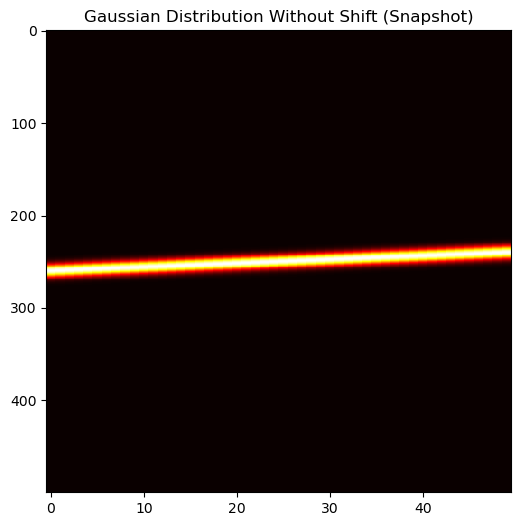

In [5]:
Q = create_gaussian_polynomial_time_matrix(rows, cols, sigma)

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(Q, cmap='hot', interpolation='nearest', aspect='auto')
ax.set_title('Gaussian Distribution Without Shift (Snapshot)')

plt.show()

## Split the data

In [6]:
coefficients = [5,-2,10]
degree = 2

In [7]:
def calculate_shift(t, coefficients, degree):
    shift = coefficients[0] * np.ones((t.shape[0], 1))
    for i in range(1, degree + 1):
        shift += coefficients[i] * np.sum(t**i, axis=1, keepdims=True)
    return shift

In [8]:
indices = np.arange(cols)
np.random.seed(42)
np.random.shuffle(indices)
train_ratio = 0.8
train_size = int(cols * train_ratio)
test_size = cols - train_size
train_indices = indices[:train_size]
test_indices = indices[train_size:]
train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

X_train, X_test = Q[:, train_indices], Q[:, test_indices]

y_train = calculate_shift(X_train,coefficients,degree)
y_test = calculate_shift(X_test,coefficients,degree)
# y_train = np.dot(X_train**2,a2*X_train.shape[1]) + np.dot(X_train, a1*X_train.shape[1]) + a0
# y_test = np.dot(X_test**2,a2*X_test.shape[1]) + np.dot(X_test, a1*X_test.shape[1]) + a0

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(500, 40) (500, 1) (500, 10) (500, 1)


In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Define a model

In [10]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, degree1, degree2, type_NN):
        super(ShiftPredictionModel, self).__init__()
        self.degree1 = degree1
        self.a_coefficients = nn.ParameterList(
            [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) for _ in range(degree1+1)]
        )
        self.b_coefficients = nn.ParameterList(
            [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) for _ in range(degree2)]
        )
        self.type_NN = type_NN
    
    def forward_pol(self,t):
        shift = self.a_coefficients[0] * torch.ones(t.size(0), 1, dtype=torch.float32)
        for i in range(1, self.degree1 + 1):
            shift += self.a_coefficients[i] * torch.sum(t**i, dim=1, keepdim=True)
        return shift
    
    def forward_rat(self,t):
        shift = self.b_coefficients[0] * torch.ones(t.size(0), 1, dtype=torch.float32)
        for i in range(1, self.degree1 + 1):
            shift += self.b_coefficients[i] * torch.sum(t**i, dim=1, keepdim=True)
        return self.forward_pol(t)/shift

    # def forward_activ(self, t):
    #     return F.relu(t)
    
    def forward(self, t):
        if self.type_NN == "polynomial":
            output = self.forward_pol(t)
        elif self.type_NN == "rational":
            output = self.forward_rat(x)
            
        return output

## Train a model

In [11]:
def total_variation(shift):
    return torch.sum(torch.abs(shift[..., 1:] - shift[..., :-1]))

def calculate_loss(true_shift,predicted_shift):
    return torch.max(torch.abs(true_shift - predicted_shift))

In [12]:
model = ShiftPredictionModel(degree1=degree,degree2=0,type_NN="polynomial") # nn.Linear(40,1)
model.to(torch.float32)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
epochs = 3000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    a_coefficients_train = [p.item() for p in model.a_coefficients]
    prediction_loss = calculate_loss(y_train,y_pred)
    tv_loss=total_variation(y_pred)
    loss = prediction_loss + 0.5 * tv_loss**2
    #loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        a_coefficients_test = torch.tensor([p.item() for p in model.a_coefficients])
        prediction_test_loss = calculate_loss(y_test,y_pred_test).item()
        tv_test_loss = total_variation(y_pred_test).item()
        test_loss = prediction_test_loss + 0.5 * tv_test_loss**2
        #test_loss = criterion(y_pred_test, y_test)
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Coefficients:{[coefficients[i] for i in range(len(coefficients))]}{a_coefficients_train}')

print(f"Model training complete.")


Epoch [0/3000], Loss: 131.8468, Test Loss: 43.4161, Coefficients:[5, -2, 10][-0.3240666687488556, -0.27177733182907104, 0.5503101348876953]
Epoch [100/3000], Loss: 9.8008, Test Loss: 6.7089, Coefficients:[5, -2, 10][-0.34406664967536926, 2.691240072250366, 3.8225536346435547]
Epoch [200/3000], Loss: 7.5022, Test Loss: 8.5691, Coefficients:[5, -2, 10][-0.42406657338142395, 2.4449026584625244, 4.61190128326416]
Epoch [300/3000], Loss: 7.9876, Test Loss: 5.7631, Coefficients:[5, -2, 10][-0.36406663060188293, 1.8622195720672607, 4.9796600341796875]
Epoch [400/3000], Loss: 4.9626, Test Loss: 6.6460, Coefficients:[5, -2, 10][0.05593331158161163, 1.7436598539352417, 5.3942108154296875]
Epoch [500/3000], Loss: 9.1868, Test Loss: 5.4055, Coefficients:[5, -2, 10][0.39593324065208435, 1.271628499031067, 5.59960412979126]
Epoch [600/3000], Loss: 7.3034, Test Loss: 4.4499, Coefficients:[5, -2, 10][0.7359329462051392, 1.0368223190307617, 5.9914398193359375]
Epoch [700/3000], Loss: 5.3666, Test Loss:

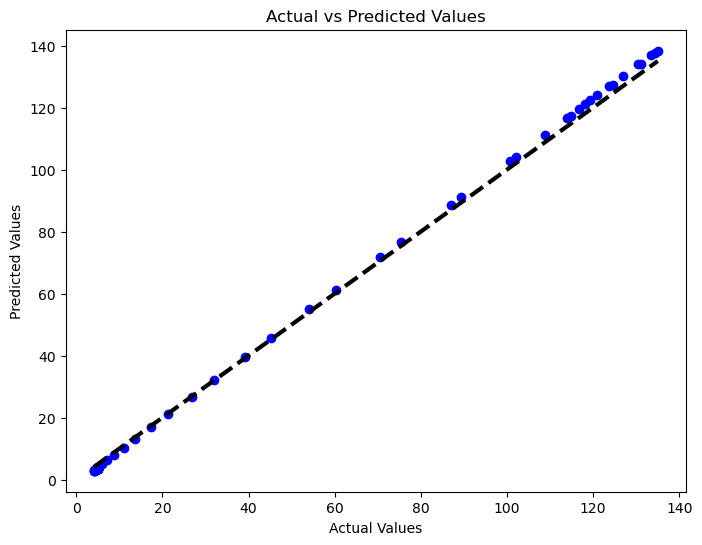

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train.detach().numpy(), y_pred.detach().numpy(), color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
plt.show()


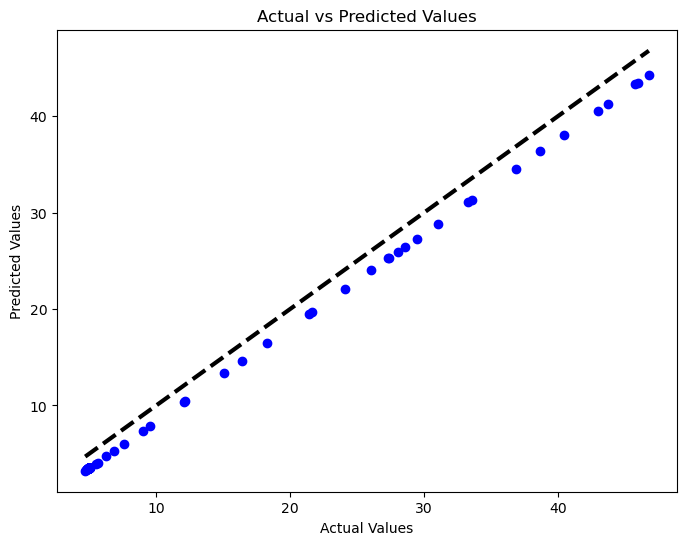

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test.detach().numpy(), y_pred_test.detach().numpy(), color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.show()